# NLP Final Project - Topic Modeling

For this final project, there is a collection of ~200K news articles on our favorite topics, data science, machine learning, and artificial intelligence. Our task is to identify what industries and job lines are going to be most impacted by AI over the next several years, based on the information/insights you can extract from this text corpus.

Goal: provide actionable recommendations on what can be done with AI to automate the jobs, improve employee productivity, and generally make AI adoption successful. Please pay attention to the introduction of novel technologies and algorithms, such as AI for image generation and Conversational AI, as they represent the entire paradigm shift in adoption of AI technologies and data science in general.


## Loading Data

In [2]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Mounted at /content/drive


In [ ]:
import pandas as pd

# Path to the CSV file in Google Drive
file_path = '/content/drive/My Drive/nlp_final/tokenized_text.json'

# Load the JSON file
df = pd.read_json(file_path, orient='records', lines=True)

# Display loaded data
df.head()


In [ ]:
df.to_csv('tokenized_text.csv', index=False, escapechar='\\')


In [ ]:
df.shape

(145456, 4)

## Create Dictionary & Corpus

In [ ]:
df = df[['topic_tokens', 'cleaned_text']]
df.shape

(145456, 2)

In [ ]:
print(type(df['topic_tokens'][69009]))

<class 'list'>


In [ ]:
# !pip install gensim

In [ ]:
from gensim import corpora

# Create a dictionary representation of the documents
dictionary = corpora.Dictionary(df['topic_tokens'])

# Filter out rare and common tokens
dictionary.filter_extremes(no_below=15, no_above=0.5)

# Create a corpus from the dictionary representation
corpus = [dictionary.doc2bow(tokens) for tokens in df['topic_tokens']]


In [ ]:
print('Number of unique tokens: %d' % len(dictionary))
print('Number of documents: %d' % len(corpus))

Number of unique tokens: 100000
Number of documents: 145456


## Save corpus

In [ ]:
import json

# Save as json using pandas
df_corpus = pd.DataFrame(corpus)
df_corpus.to_json('corpus.json', orient='records', lines=True)

In [ ]:
# Path to the json file in Google Drive
file_path = '/content/drive/My Drive/nlp_final/corpus.json'

loaded_corpus = pd.read_json(file_path, orient='records', lines=True)
loaded_corpus.head()


,0,1,2,3,4,5,6,7,8,9,...,7233,7234,7235,7236,7237,7238,7239,7240,7241,7242
0,"[0, 1]","[1, 8]","[2, 12]","[3, 12]","[4, 12]","[5, 12]","[6, 12]","[7, 12]","[8, 12]","[9, 12]",...,None,None,None,None,None,None,None,None,None,None
1,"[16, 1]","[18, 1]","[28, 2]","[30, 1]","[39, 1]","[56, 3]","[66, 1]","[69, 1]","[95, 12]","[105, 1]",...,None,None,None,None,None,None,None,None,None,None
2,"[0, 1]","[12, 1]","[15, 1]","[16, 3]","[18, 3]","[20, 1]","[25, 1]","[30, 1]","[39, 2]","[45, 1]",...,None,None,None,None,None,None,None,None,None,None
3,"[0, 1]","[11, 1]","[12, 4]","[30, 1]","[37, 2]","[39, 1]","[46, 1]","[51, 2]","[67, 1]","[72, 1]",...,None,None,None,None,None,None,None,None,None,None
4,"[18, 1]","[22, 2]","[30, 1]","[31, 1]","[37, 1]","[58, 2]","[87, 2]","[90, 1]","[117, 1]","[129, 1]",...,None,None,None,None,None,None,None,None,None,None


## LDA Topic Modeling

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from gensim.models import Phrases, LdaModel, LdaMulticore


### Tuning Number of Topics

In [ ]:
min_topics = 8
max_topics = 20
step_size = 1
topics_range = range(min_topics, max_topics + 1, step_size)
chunksize = 30 # number of documents to be used in each training chunk
passes = 10 # epochs
eval_every = 50  # affects speed and quality of the model, can increase for larger datasets

coherence_scores = []

for num_topics in topics_range:
    model = LdaMulticore(
        corpus=corpus,
        id2word=dictionary,
        alpha='asymmetric',
        eta='auto',
        passes=passes,
        eval_every=eval_every,
        workers=3
    )

    # Compute Coherence Score
    coherence_model = CoherenceModel(model=model, texts=corpus, dictionary=dictionary, coherence='c_v')
    coherence_score = coherence_model.get_coherence()
    coherence_scores.append(coherence_score)

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


NameError: name 'normalized_corpus' is not defined

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(topics_range, coherence_scores, marker='o')
plt.title("Coherence Scores by Number of Topics")
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score")
plt.xticks(topics_range)
plt.show()

### Training Model

In [ ]:
model = LdaModel(
    corpus=corpus,
    id2word=dictionary,
    alpha="asymmetric",
    eta='auto',
    num_topics=18,
    passes=10,
    eval_every=300,
    random_state=0
)

In [ ]:
model.show_topics(num_words=20)

In [ ]:
document_topics = [model.get_document_topics(doc) for doc in corpus]

df['topic'] = document_topics
print(df['topic'].value_counts())
df.head()

In [ ]:
texts = df['cleaned_text']
# Get the document-topic distribution
doc_topic_dist = model.transform(texts)

In [ ]:
!pip install umap-learn

import umap
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/usr/local/lib/python3.10/dist-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


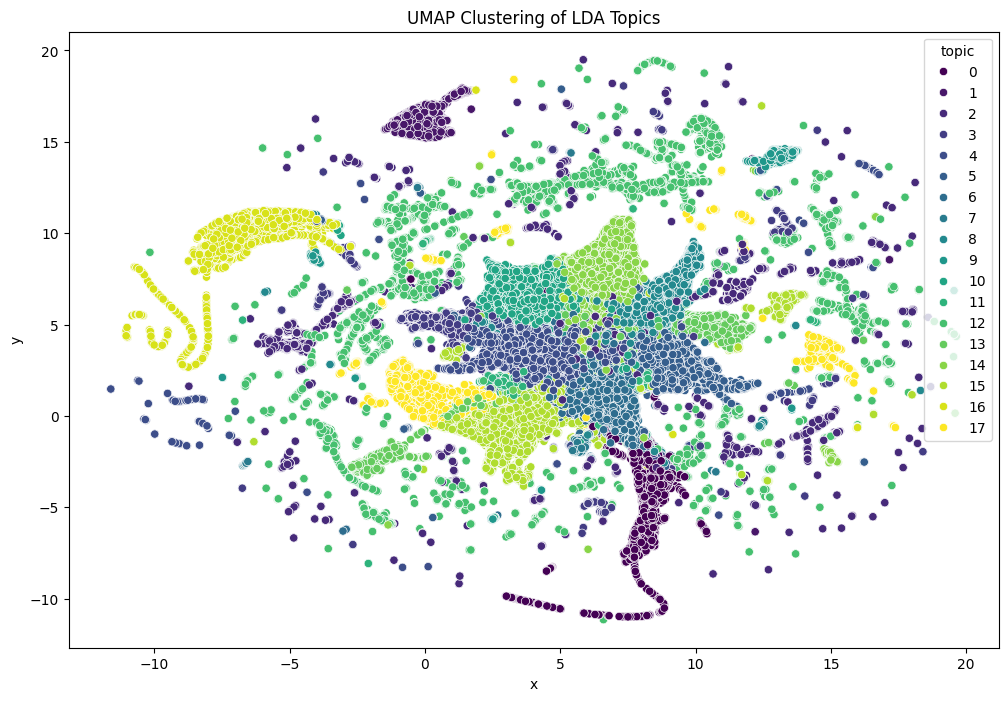

In [ ]:
# Reduce dimensionality using UMAP
umap_model = umap.UMAP(n_components=2, random_state=42)
umap_lda = umap_model.fit_transform(doc_topic_dist)

# Create a DataFrame for visualization
umap_df = pd.DataFrame(umap_lda, columns=['x', 'y'])
umap_df['topic'] = np.argmax(doc_topic_dist, axis=1)

# Plot the UMAP results
plt.figure(figsize=(12, 8))
sns.scatterplot(x='x', y='y', hue='topic', palette='viridis', data=umap_df, legend='full')
plt.title('UMAP Clustering of LDA Topics')
plt.show()

## Labeling Topics

Prompted ChatGPT 4o with: "Can you label each topic?
Topic 1:
stocks stock market ai nasdaq markets news trading investment data
Topic 2:
services products news technology entertainment business media consumer policy general
Topic 3:
ai generative gray media technology 2023 group content new global
Topic 4:
health medical healthcare care patients clinical news patient cancer drug
Topic 5:
ai intelligence human data technology artificial new systems like research
Topic 6:
ai data news business technology cloud digital security new management
Topic 7:
ai openai said share news best company new price tech
Topic 8:
digi 2020 communications 2019 nv 2021 icon 2018 january december
Topic 9:
data ai learning machine business customer science insurance use models
Topic 10:
new newswires south ai news releases north ein industry media
Topic 11:
news india world ai business share 2023 technology latest entertainment
Topic 12:
republic email account subscribe news password log sign facebook twitter
Topic 13:
ai gray data group media release press platform technology statements
Topic 14:
new music radio news star public npr says schedule shows
Topic 15:
ai 2023 best chatgpt new google news users tech mobile
Topic 16:
news ai said artificial new intelligence public 2023 weather technology
Topic 17:
market intelligence artificial report global analysis growth research industry forecast
Topic 18:
ago hours news video stories weather 2023 app said new"

#### ChatGPT
Sure, I'll assign labels to each topic based on the provided keywords.

**Topic 1: Financial Markets and AI**
- stocks, stock, market, ai, nasdaq, markets, news, trading, investment, data

**Topic 2: Technology and Consumer Services**
- services, products, news, technology, entertainment, business, media, consumer, policy, general

**Topic 3: Generative AI and Media**

- ai, generative, gray, media, technology, 2023, group, content, new, global

**Topic 4: Healthcare and Medical News**
- health, medical, healthcare, care, patients, clinical, news, patient, cancer, drug

**Topic 5: Artificial Intelligence Research**
- ai, intelligence, human, data, technology, artificial, new, systems, like, research

**Topic 6: Business and Digital Security**
- ai, data, news, business, technology, cloud, digital, security, new, management

**Topic 7: AI and Tech Companies**
- ai, openai, said, share, news, best, company, new, price, tech

**Topic 8: Digital Communications**
-digi, 2020, communications, 2019, nv, 2021, icon, 2018, january, december

**Topic 9: Data Science and Machine Learning**
- data, ai, learning, machine, business, customer, science, insurance, use, models

**Topic 10: Regional News and Industry Updates**
- new, newswires, south, ai, news, releases, north, ein, industry, media

**Topic 11: India and Global Technology News**
- news, india, world, ai, business, share, 2023, technology, latest, entertainment

**Topic 12: Online Accounts and Social Media**
- republic, email, account, subscribe, news, password, log, sign, facebook, twitter

**Topic 13: Media Releases and Technology Platforms**
- ai, gray, data, group, media, release, press, platform, technology, statements

**Topic 14: Music and Public Radio**
- new, music, radio, news, star, public, npr, says, schedule, shows

**Topic 15: AI and Mobile Technology**
- ai, 2023, best, chatgpt, new, google, news, users, tech, mobile

**Topic 16: General AI and Technology News**
- news, ai, said, artificial, new, intelligence, public, 2023, weather, technology

**Topic 17: Market Research and Forecasts**
- market, intelligence, artificial, report, global, analysis, growth, research, industry, forecast

**Topic 18: General News and Weather Updates**
- ago, hours, news, video, stories, weather, 2023, app, said, new

These labels should help in understanding the content of each topic cluster better.









In [ ]:
topic_labels = [
    "1. Financial Markets and AI",
    "2. Technology and Consumer Services",
    "3. Generative AI and Media",
    "4. Healthcare and Medical News",
    "5. Artificial Intelligence Research",
    "6. Business and Digital Security",
    "7. AI and Tech Companies",
    "8. Digital Communications",
    "9. Data Science and Machine Learning",
    "10. Regional News and Industry Updates",
    "11. India and Global Technology News",
    "12. Online Accounts and Social Media",
    "13. Media Releases and Technology Platforms",
    "14. Music and Public Radio",
    "15. AI and Mobile Technology",
    "16. General AI and Technology News",
    "17. Market Research and Forecasts",
    "18. General News and Weather Updates"
]

## BERTopic

In [ ]:
!pip install bertopic

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 kB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 24.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 171.5/171.5 kB 17.6 MB/s eta 0:00:00
  Using cached Cython-0.29.37-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_24_x86_64.whl (1.9 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 5.6 MB/s eta 0:00:00
  Created wheel for hdbscan: filename=hdbscan-0.8.33-cp310-cp310-linux_x86_64.whl size=3039286 sha256=2a00ad6279a72745763d930dc080df84a42ebed26ae8fa0c699145ec8070ba8b
  Stored in directory: /root/.cache/pip/wheels/75/0b/3b/dc4f60b7cc455efaefb62883a7483e76f09d06ca81cf87d610
Successfully built hdbscan


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

from umap import UMAP
from hdbscan import HDBSCAN
from sentence_transformers import SentenceTransformer

from bertopic import BERTopic
from bertopic.vectorizers import ClassTfidfTransformer

import numpy as np

### Embedding Model

In [ ]:
# instantiating the embedding model
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")

# Encoding the entire corpus to get the embeddings
embeddings = embedding_model.encode(corpus, show_progress_bar=True)


In [ ]:
# save embeddings

np.save('embeddings.npy', corpus_embeddings)  # Save

In [ ]:
loaded_embeddings = np.load('embeddings.npy')  # Load

In [ ]:
# Outputting the results
print("Number of sentences:", len(loaded_embeddings))
for i, embedding in enumerate(loaded_embeddings):
    print(f"\nEmbedding for sentence {i+1} (Dimensions: {len(embedding)}):")
    print(embedding)

### HDBSCAN Clustering

In [ ]:
hdbscan_model = HDBSCAN(min_cluster_size=780, metric='euclidean', cluster_selection_method='eom', prediction_data=True)

### Topic Representation

In [ ]:
# Tokenize topics
vectorizer_model = CountVectorizer(stop_words="english", ngram_range=(1, 2))

# Create topic representation
ctfidf_model = ClassTfidfTransformer()

## Model

In [ ]:
topic_model = BERTopic(
      embedding_model=embedding_model,
      hdbscan_model=hdbscan_model,
      vectorizer_model=vectorizer_model,
      ctfidf_model=ctfidf_model=ctfidf_model)


In [ ]:
# training model
topics, probs = topic_model.fit_transform(df['cleaned_text'], loaded_embeddings)


In [ ]:
# topics contains the topic assignment for each document

print(
    len(topics) == len(df["cleaned_text"]),
    topics[:10], # topics assignments of first 10 articles
    sep="\n\n"
)

## Topics

In [ ]:
# probs that store probabilities of each topic

probs[:10]

In [ ]:
# topics from the model

topic_model.get_topic_info()

In [ ]:
topic_model.get_topics()

In [ ]:
# accessing the frequent topics
topic_model.get_document_info(df["cleaned_text"])

In [ ]:
print(len(topic_model.get_topics()))


In [ ]:
# visualization can get at the idea their may be little practical difference between clusters
topic_model.visualize_topics()

Ask ChatGPT to identify the labels of each topic -> create labels.

### Save topics

In [ ]:
# Get the topic information
topic_info = topic_model.get_topic_info()

# Save the topic information to a CSV file
topic_info.to_csv('topic_info.csv', index=False)

# Alternatively, save to JSON
topic_info.to_json('topic_info.json', orient='records', lines=True)


In [ ]:
# Create a dictionary to store the topic representations
topic_representations = {}

# Iterate over each topic
for topic in topic_info['Topic']:
    if topic != -1:  # Skip outliers
        topic_representations[topic] = topic_model.get_topic(topic)

# Save the topic representations to a JSON file
with open('topic_representations.json', 'w') as f:
    json.dump(topic_representations, f, indent=4)


In [ ]:
# Add topic and probability columns to the original DataFrame
df['topic'] = topics
df['probability'] = probs

# # Save the DataFrame to a CSV file
# df.to_csv('document_topic_assignments.csv', index=False)

# Alternatively, save to JSON
df.to_json('document_topic_assignments.json', orient='records', lines=True)
